In [1]:
import transformers
print(transformers.__version__)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4.39.3


In [ ]:
!pip install --upgrade transformers

In [2]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForMaskedLM
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import random

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Save the tokenizer
tokenizer.save_pretrained('/content/drive/MyDrive/MINORPROJECT')




('/content/drive/MyDrive/MINORPROJECT/tokenizer_config.json',
 '/content/drive/MyDrive/MINORPROJECT/special_tokens_map.json',
 '/content/drive/MyDrive/MINORPROJECT/vocab.txt',
 '/content/drive/MyDrive/MINORPROJECT/added_tokens.json')

In [3]:
pwd

'/Users/ravi/Downloads'

In [4]:
ls

205122077_Minor_Project.pdf  NITTIDCARD.pdf
MINORPROJECT_Model/          PlacementRavi.txt
MinorProjectBert.ipynb


In [5]:
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('/Users/ravi/Downloads/MINORPROJECT_Model')

In [6]:
def clean_text(line):
    line = re.sub(r'-+',' ',line) #Removes repeated hyphens (e.g., '---' becomes ' ')
    line = re.sub(r'[^a-zA-Z, ]+'," ",line) #Removes non-alphanumeric characters except for spaces and commas (e.g., '!"#$%&()*+' becomes ' ')
    line = re.sub(r'[ ]+'," ",line)#Replaces multiple spaces with a single space
    return line

In [7]:
def random_mask(text, mask_rate=0.15):
    """Masks a random subset of words in the text with a specified mask rate."""
    tokenized_text = tokenizer.tokenize(text)
    num_mask = int(len(tokenized_text) * mask_rate)
    mask_indices = random.sample(range(len(tokenized_text)), num_mask)
    for idx in mask_indices:
        tokenized_text[idx] = '[MASK]'
    return tokenizer.convert_tokens_to_string(tokenized_text)


In [11]:
text = '''We first construct a nonnegative dictionary based on prototype elements from the training images; this problem is formulated as a regularized non-negative matrix. Incorporating the dictionary as a prior in a convex reconstruction problem, we then find an approximate solution with a sparse representation in the dictionary.'''

print(random_mask(text))

we first construct a [MASK]negative dictionary based on prototype elements from the training images ; this [MASK] [MASK] formulated as [MASK] regularized non - [MASK] matrix . incorporating the dictionary as a [MASK] in a convex reconstruction [MASK] , we [MASK] find an approximate solution with a sparse representation in the dictionary .


In [9]:
def prepare_data(data_file, max_length=128):

    inputs = []
    attention_masks = []
    labels = []
    with open(data_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    for line in lines:
        # Clean the text before further processing
        cleaned_line = clean_text(line.strip())

        if len(cleaned_line.split(" ")) >= 20:  # Minimum word count filter
            masked_text = random_mask(cleaned_line)
            tokenized_text = tokenizer(masked_text, add_special_tokens=True, truncation=True, padding='max_length', return_tensors='tf')
            # print("tokenized text", tokenized_text)
            input_ids = tokenized_text['input_ids']
            attention_mask = tokenized_text['attention_mask']
            inputs.append(input_ids)
            attention_masks.append(attention_mask)
            labels.append(tokenizer(cleaned_line, add_special_tokens=True, truncation=True, padding='max_length', return_tensors='tf')['input_ids'])

    inputs = tf.concat(inputs, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)
    labels = tf.concat(labels, axis=0)

    return inputs, attention_masks, labels

In [ ]:

data_file = "/content/drive/MyDrive/MINORPROJECT/train.txt"


inputs, attention_masks, labels = prepare_data(data_file)

print(f"Number of processed lines: {inputs.shape[0]}")
print(f"Sample input IDs shape: {inputs[0].shape}")
print(f"Sample attention mask shape: {attention_masks[0].shape}")
print(f"Sample labels shape: {labels[0].shape}")

Number of processed lines: 2963
Sample input IDs shape: (512,)
Sample attention mask shape: (512,)
Sample labels shape: (512,)


In [ ]:
model = TFBertForMaskedLM.from_pretrained('bert-base-uncased')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))





model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForMaskedLM.

All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


In [ ]:
tf.config.run_functions_eagerly(True)

history = model.fit([inputs, attention_masks], labels, verbose=1, batch_size=4, epochs=10)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
741/741 [==============================] - 897s 1s/step - loss: 0.6626
Epoch 2/10
741/741 [==============================] - 886s 1s/step - loss: 0.3633
Epoch 3/10
741/741 [==============================] - 898s 1s/step - loss: 0.2749
Epoch 4/10
741/741 [==============================] - 898s 1s/step - loss: 0.2139
Epoch 5/10
741/741 [==============================] - 905s 1s/step - loss: 0.1733
Epoch 6/10
741/741 [==============================] - 916s 1s/step - loss: 0.1409
Epoch 7/10
741/741 [==============================] - 911s 1s/step - loss: 0.1091
Epoch 8/10
741/741 [==============================] - 908s 1s/step - loss: 0.0895
Epoch 9/10
741/741 [==============================] - 913s 1s/step - loss: 0.0761
Epoch 10/10
741/741 [==============================] - 904s 1s/step - loss: 0.0705


In [ ]:
# Save the model
model.save_pretrained('/content/drive/MyDrive/MINORPROJECT')




In [12]:
# Load the model
model = TFBertForMaskedLM.from_pretrained('/Users/ravi/Downloads/MINORPROJECT_Model')

All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at /Users/ravi/Downloads/MINORPROJECT_Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


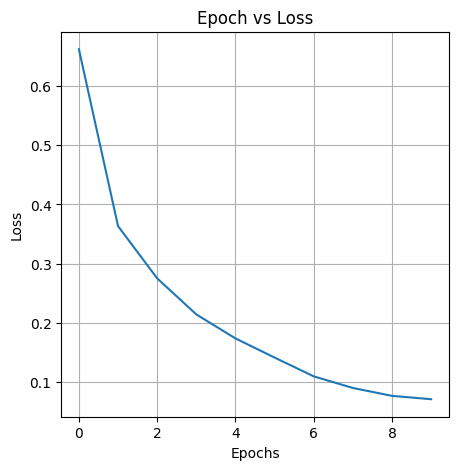

In [ ]:
losses = history.history['loss']
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
ax1.plot(range(len(losses)),losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Epoch vs Loss")
plt.grid()
plt.show()

In [15]:
!pip install nltk
!pip install rake_nltk
import nltk,rake_nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


False

In [16]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


False

In [14]:
from rake_nltk import Rake

rake = Rake()

text = '''The invention discloses high precision biochemistry instrument cleaning equipment which comprises a shell. A cleaning cavity is formed in the shell, a rising cavity is formed in the position, below the cleaning cavity, in the shell, a transverse groove arranged in a left-and-right extending manner is formed in the top in the cleaning cavity, a sliding connecting block is arranged in the transverse groove, and a cleaning motor is fixedly arranged on the front side end face of the sliding connecting block; a cleaning brush which extends into the cleaning cavity and is in rotary connection with the cleaning cavity is arranged at the bottom of the cleaning motor, the left and right side of the cleaning cavity are each provided with a first guide groove and a second guide groove formed above the first guide groove, a first guide rod arranged in an up-and-down extending manner is arranged in each first guide groove, and a first groove position is arranged at the top in each second guide groove; and a second guide rod arranged in an up-and-down extending manner is arranged in each first groove position, and a rising table with the left and right sides extending into the first guide grooves which are located on the left and right sides and are in sliding connection with the first guide rods is arranged in the cleaning cavity. The high precision biochemistry instrument cleaning equipment is simple in structure, high in working efficiency and low in manufacturing cost and maintaining cost.'''

# Extract keywords from text
rake.extract_keywords_from_text(text)

# Get keyword phrases ranked highest to lowest with scores
keywords_with_scores = rake.get_ranked_phrases_with_scores()


keywords = rake.get_ranked_phrases()
for score, keyword in keywords_with_scores:
    print(f"Score: {score}, Phrase: {keyword}")

print(keywords)
# Threshold for masking
threshold = 11.0

# Mask phrases with scores greater than the threshold
masked_text = text
for score, keyword in keywords_with_scores:
    if score > threshold:
        masked_text = masked_text.replace(keyword, '[MASK]')

print('\nOriginal text: ',text)
print("\n\n\nMasked Text: ",masked_text)

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/ravi/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.12/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.12/share/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.12/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
sample_text = masked_text
inp = tokenizer(sample_text, return_tensors='tf')
mask_loc = np.where(inp.input_ids.numpy()[0]==103)[0].tolist()
out = model(inp).logits[0].numpy()
predicted_tokens = np.argmax(out[mask_loc],axis=1).tolist()
predicted_output=sample_text
#eplace all [MASK] with predicted tokens
for token in predicted_tokens:
    predicted_word = tokenizer.decode([token])
    print('predicted_word: ',predicted_word)
    predicted_output = predicted_output.replace('[MASK]', predicted_word, 1)

print('Original Masked Text: ',sample_text)
print('Predicted Infilled Text: ',predicted_output)


predicted_word:  cleaning
predicted_word:  top
predicted_word:  top
predicted_word:  top
predicted_word:  table
predicted_word:  design
Original Masked Text:  The [MASK] which comprises a shell. A cleaning cavity is formed in the shell, a rising cavity is formed in the position, below the cleaning cavity, in the shell, a transverse groove arranged in a left-and-right extending manner is formed in the top in the cleaning cavity, a sliding connecting block is arranged in the transverse groove, and a cleaning motor is fixedly arranged on the [MASK] of the sliding connecting block; a cleaning brush which extends into the cleaning cavity and is in rotary connection with the cleaning cavity is arranged at the bottom of the cleaning motor, the left and right side of the cleaning cavity are each provided with a first guide groove and a [MASK] above the first guide groove, a [MASK] in an up-and-down extending manner is arranged in each first guide groove, and a first groove position is arranged

In [ ]:
import numpy as np


# Number of samples for each masked position
num_samples = 5

# Predicted tokens for each masked position
predicted_tokens = []

for loc in mask_loc:
    logits = out[loc]

    # Sampling from logits
    sampled_indices = np.random.choice(len(logits), size=num_samples, p=np.exp(logits) / np.sum(np.exp(logits)))
    predicted_tokens.append(sampled_indices.tolist())

# Decoding predicted tokens
decoded_words = [[tokenizer.decode([token]) for token in tokens] for tokens in predicted_tokens]

# Print decoded output
for i, words in enumerate(decoded_words):
    print(f"Predictions for masked position {i + 1}:")
    for j, word in enumerate(words):
        print(f"Sample {j + 1}: {word}")
    print()

Predictions for masked position 1:
Sample 1: cleaning
Sample 2: apparatus
Sample 3: apparatus
Sample 4: cleaning
Sample 5: apparatus

Predictions for masked position 2:
Sample 1: top
Sample 2: top
Sample 3: top
Sample 4: bottom
Sample 5: top

Predictions for masked position 3:
Sample 1: top
Sample 2: top
Sample 3: top
Sample 4: top
Sample 5: top

Predictions for masked position 4:
Sample 1: top
Sample 2: panel
Sample 3: design
Sample 4: top
Sample 5: chassis

Predictions for masked position 5:
Sample 1: table
Sample 2: table
Sample 3: stop
Sample 4: light
Sample 5: podium

Predictions for masked position 6:
Sample 1: structure
Sample 2: structure
Sample 3: design
Sample 4: structure
Sample 5: design



In [ ]:
def penalized_decoding(masked_text, model, tokenizer, penalty_factor=1.2, temperature=1.0, num_predictions=3):
    inp = tokenizer(masked_text, return_tensors='tf')
    mask_loc = np.where(inp.input_ids.numpy()[0] == 103)[0].tolist()
    out = model(inp).logits[0].numpy()

    # Apply temperature scaling
    out[mask_loc] = out[mask_loc] / temperature

    # Apply penalty
    out[mask_loc] = out[mask_loc] / penalty_factor

    # Generate multiple predictions
    predicted_outputs = []
    for _ in range(num_predictions):
        predicted_tokens = []
        for loc in mask_loc:
            logits = out[loc]
            probabilities = tf.nn.softmax(logits).numpy()

            # Find the top 95% of the distribution
            sorted_indices = np.argsort(probabilities)[::-1]
            cumulative_probs = np.cumsum(probabilities[sorted_indices])
            top_95_mask = cumulative_probs <= 0.95
            top_95_indices = sorted_indices[top_95_mask]

            # Normalize the probabilities
            top_95_probabilities = probabilities[top_95_indices]
            top_95_probabilities /= np.sum(top_95_probabilities)

            # Sample from the top 95% of the probability distribution
            token_id = np.random.choice(top_95_indices, p=top_95_probabilities)
            predicted_tokens.append(token_id)

        predicted_output = masked_text
        for token in predicted_tokens:
            predicted_word = tokenizer.decode([token]).strip()
            predicted_output = predicted_output.replace('[MASK]', predicted_word, 1)

        predicted_outputs.append(predicted_output)

    return predicted_outputs

sample_text = masked_text

# Generate 5 predictions with temperature and penalty factor
predicted_outputs = penalized_decoding(sample_text, model, tokenizer, penalty_factor=1.2, temperature=1.0, num_predictions=5)
print('Original Masked Text:', sample_text)
for i, predicted_output in enumerate(predicted_outputs, start=1):
    print(f'Prediction {i}: {predicted_output}')

Original Masked Text: The [MASK] which comprises a shell. A cleaning cavity is formed in the shell, a rising cavity is formed in the position, below the cleaning cavity, in the shell, a transverse groove arranged in a left-and-right extending manner is formed in the top in the cleaning cavity, a sliding connecting block is arranged in the transverse groove, and a cleaning motor is fixedly arranged on the [MASK] of the sliding connecting block; a cleaning brush which extends into the cleaning cavity and is in rotary connection with the cleaning cavity is arranged at the bottom of the cleaning motor, the left and right side of the cleaning cavity are each provided with a first guide groove and a [MASK] above the first guide groove, a [MASK] in an up-and-down extending manner is arranged in each first guide groove, and a first groove position is arranged at the top in each second guide groove; and a [MASK] in an up-and-down extending manner is arranged in each first groove position, and a